# [Transformer Pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines)

## [주요 파라미터](https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline)

- `task`: The task defining which pipeline will be returned.
  - "text-generation", "audio-classification", "image-to-text" 등
- `model`: The model that will be used by the pipeline to make predictions.
- `config(optional)`: The configuration that will be used by the pipeline to instantiate the model.
- `tokenizer(optional)`: The tokenizer that will be used by the pipeline to encode data for the model.

## [Pipeline 내부 프로세스](https://huggingface.co/learn/nlp-course/ko/chapter2/2?fw=pt)
- 파이프라인은 전처리(preprocessing), 모델로 입력 전달 및 후처리(postprocessing)의 3단계를 한번에 실행합니다.

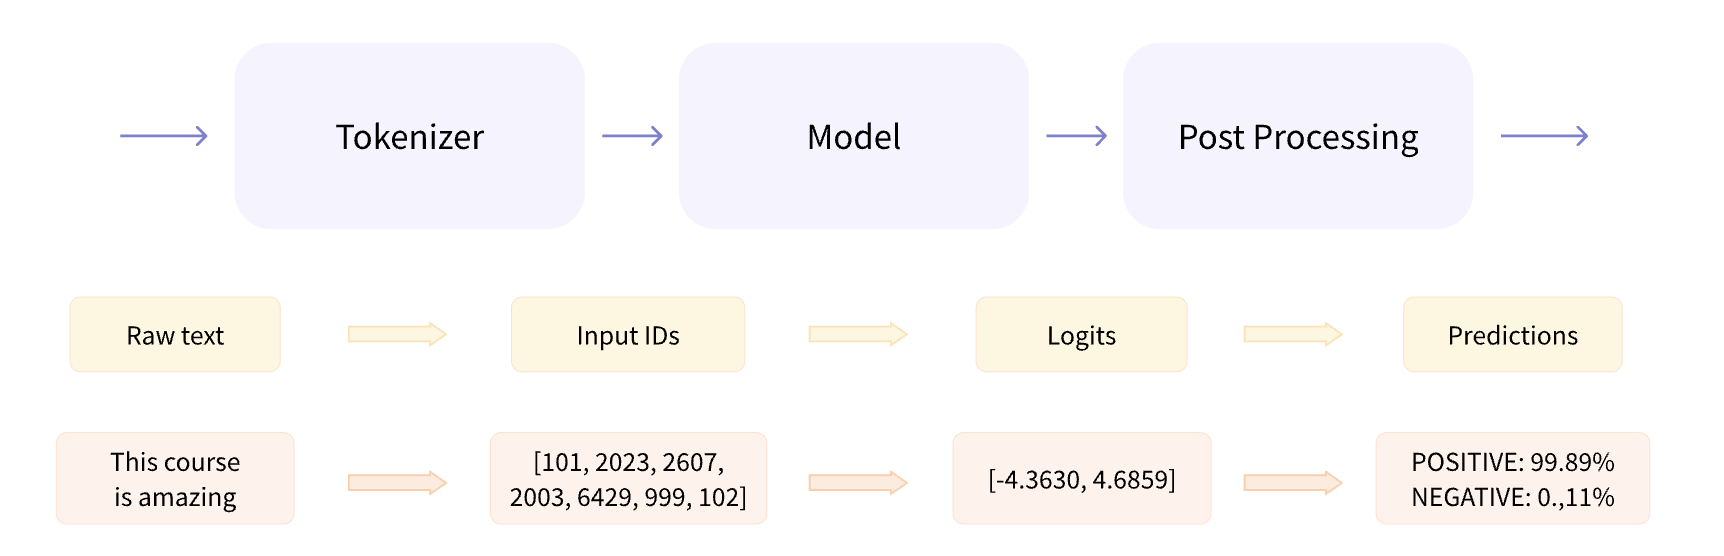

### install

In [ ]:
!pip install transformers==4.56.1 sentencepiece==0.2.1

### Tokenizer

#### 단어 기반 토큰화 (Word-based Tokenization)
- 가장 먼저 생각할 수 있는 토큰화(tokenization) 형태는 단어기반 (word-based) 입니다.
- 일반적으로 몇 가지 규칙만 가지고도 설정 및 사용이 매우 쉽고, 종종 괜찮은 결과를 얻을 수 있습니다.

예를 들어, 아래 그림에서의 토큰화 과정은 원시 텍스트를 단어로 나누고 각각에 대한 숫자 표현을 찾는 것입니다:

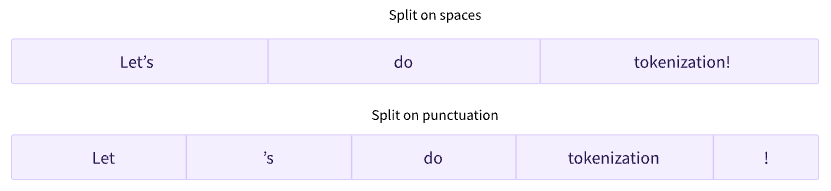

In [ ]:
# 단어 기반 토큰화의 간단한 예시
# split() 메서드를 사용하여 공백을 기준으로 문장을 단어 단위로 분리
tokenized_text = "Jim Henson was a puppeteer".split()
print("토큰화된 결과:", tokenized_text)
print(f"토큰 개수: {len(tokenized_text)}개")

['Jim', 'Henson', 'was', 'a', 'puppeteer']


단어기반 토크나이저로 특정 언어를 완전히 커버하려면, 해당 언어의 모든 단어에 대한 식별자가 필요하고, 이는 엄청난 양의 토큰을 생성합니다.
- 예를 들어, 영어에는 500,000개 이상의 단어가 있으므로 개별 단어에 대한 input ID(입력 식별자)로의 매핑을 구성하기 위해서 그만큼의 식별자들을 감당해야 합니다.
- 게다가, "dog"와 같은 단어는 "dogs"와 같은 단어와 다르게 표현되며, 모델은 처음에는 "dog"와 "dogs"가 유사한 단어들인지 파악하기 어렵습니다.
- 따라서, 두 단어를 관련이 없는 것으로 인식합니다. 이는 "run"과 "running"과 같은 다른 유사한 단어들도 마찬가지 입니다.

마지막으로, 어휘집(vocabulary)에 없는 단어를 표현하기 위해 사용자 정의 토큰이 필요합니다.
- 이는 "unknown" 토큰으로 알려져 있으며, 종종 "[UNK]" 또는 ""로 표시됩니다.
- 토크나이저가 이러한 "unknown" 토큰을 많이 생성한다는 것은 토크나이저가 해당 단어의 합당한 표현(sensible representation)을 찾을 수 없고, 그 과정에서 정보를 잃어버린다는 뜻이므로 나쁜 징조입니다.
- 어휘집(vocabulary)을 만들 때, 토크나이저가 이러한 "unknown" 토큰들을 최대한 적게 출력하게끔 하는 것이 목표가 되어야 합니다.

#### 토크나이저 로딩 및 저장
- 토크나이저를 로드하고 저장하는 것은 모델의 경우처럼 간단합니다.
- 실제로, 모델을 로드하고 저장할 때와 같이, `from_pretrained()` 및 `save_pretrained()` 메서드(method)를 그대로 사용합니다.
- 이들 메서드(method)들은 토크나이저(모델의 아키텍처와 약간 비슷함)와 어휘집(vocabulary, 모델의 가중치(weights)와 비슷함)에서 사용하는 알고리즘을 로드하거나 저장합니다.

`AutoModel` 클래스와 유사하게 `AutoTokenizer` 클래스는 라이브러리에서 체크포인트 이름에 해당하는 토크나이저 클래스를 가져옵니다. 라이브러리 내의 다른 모든 체크포인트와 함께 직접 사용할 수 있습니다.

In [ ]:
# Hugging Face Transformers의 AutoTokenizer를 사용하여 BERT 토크나이저 로드
# bert-base-cased: 대소문자를 구분하는 BERT 모델의 기본 토크나이저
from transformers import AutoTokenizer

# 사전 훈련된 BERT 모델의 토크나이저를 불러오기
# "bert-base-cased"는 12개 레이어, 768개 히든 유닛, 12개 어텐션 헤드를 가진 모델
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
print("BERT 토크나이저가 성공적으로 로드되었습니다.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# 토크나이저를 사용하여 텍스트를 처리
# 이 메서드는 내부적으로 다음 단계들을 수행합니다:
# 1. 토큰화 (Tokenization): 텍스트를 토큰으로 분리
# 2. 입력 ID 변환: 각 토큰을 숫자 ID로 변환
# 3. 어텐션 마스크 생성: 실제 토큰과 패딩 토큰을 구분
result = tokenizer("Using a Transformer network is simple")
print("토크나이저 결과:")
print(result)

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

토크나이저를 저장하는 것은 모델을 저장하는 것과 동일합니다.

In [ ]:
# 토크나이저를 로컬 폴더에 저장
# 저장되는 파일들:
# - tokenizer_config.json: 토크나이저 설정
# - vocab.txt: 어휘집 파일
# - special_tokens_map.json: 특수 토큰 매핑
tokenizer.save_pretrained("saving_folder")
print("토크나이저가 'saving_folder'에 저장되었습니다.")

('saving_folder/tokenizer_config.json',
 'saving_folder/special_tokens_map.json',
 'saving_folder/vocab.txt',
 'saving_folder/added_tokens.json',
 'saving_folder/tokenizer.json')

#### 인코딩 (Encoding)
- 텍스트를 숫자로 변환하는(translating text to numbers) 과정을 인코딩(encoding) 이라고 합니다.
- 인코딩(encoding)은 토큰화와 입력 식별자(input IDs)로의 변환이라는 2단계 프로세스로 수행됩니다.
  - 토큰화 프로세스는 토크나이저의 `tokenize()` 메서드에 의해 수행됩니다.
  - 각 토큰들의 입력 식별자(input IDs)로의 변환은 `convert_tokens_to_ids()` 메서드에 의해 처리됩니다.

In [ ]:
from transformers import AutoTokenizer

# BERT 토크나이저 다시 로드 (이미 로드되어 있지만 예시를 위해)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"

# 1단계: 토큰화 - 텍스트를 서브워드 토큰으로 분리
# BERT는 WordPiece 토큰화를 사용하여 단어를 더 작은 단위로 분해
tokens = tokenizer.tokenize(sequence)
print("토큰화 결과:", tokens)
print(f"토큰 개수: {len(tokens)}개")
print("주목: 'Transformer'가 'Trans'와 '##former'로 분리되었습니다.")

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


In [ ]:
# 2단계: 토큰을 입력 ID로 변환
# 각 토큰을 모델이 이해할 수 있는 숫자 ID로 변환
# 이 ID들은 토크나이저의 어휘집(vocabulary)에서의 인덱스
ids = tokenizer.convert_tokens_to_ids(tokens)
print("입력 ID:", ids)
print("토큰 -> ID 매핑:")
for token, id in zip(tokens, ids):
    print(f"  '{token}' -> {id}")

[7993, 170, 13809, 23763, 2443, 1110, 3014]


#### 디코딩 (Decoding)
- 디코딩(decoding)은 반대 방향으로 진행됩니다. 변환된 입력 식별자(input IDs)를 이용해서 어휘집(vocabulary)에서 해당 문자열을 찾습니다. 이것은 다음과 같이 `decode()` 메서드를 사용하여 수행할 수 있습니다.

In [ ]:
# 디코딩: 입력 ID를 다시 텍스트로 변환
# 모델의 출력 ID를 사람이 읽을 수 있는 텍스트로 복원
decoded_string = tokenizer.decode(ids)

print("디코딩 결과:", decoded_string)
print("원본 텍스트와 동일한지 확인:", decoded_string == sequence)

Using a Transformer network is simple


### Model
- 이 섹션에서는 모델을 생성하고 사용하는 방법을 자세히 살펴보겠습니다. 이를 위해, 우리는 지정된 체크포인트(checkpoint)를 바탕으로 모델을 인스턴스화할 때 편리한 `AutoModel` 클래스를 사용할 것입니다.
- `AutoModel` 클래스와 이와 관련된 모든 항목들은 실제로 라이브러리에서 사용할 수 있는 다양한 모델에 대한 단순한 래퍼(wrapper)입니다. 당신이 선택한 체크포인트(checkpoint)에 적합한 모델 아키텍처(model architecture)를 자동으로 추측한 다음 이 아키텍처로 모델을 인스턴스화할 수 있으므로 영리한 래퍼(wrapper)라고 볼 수 있습니다.

#### 트랜스포머 모델 생성하기
- 해당모델은 학습을 하지 않은 상태이다.
- 즉, 사용을 하기 위해서는 충분한 학습을 한 후에 사용을 해야 한다.

In [ ]:
from transformers import AutoConfig, AutoModel

# 방법 1: 설정을 먼저 로드한 후 모델 생성
# 이 방법은 모델 아키텍처만 생성하고 사전 훈련된 가중치는 로드하지 않음
# (따라서 모델을 사용하기 전에 추가 학습이 필요)
print("BERT 모델 설정을 로드하는 중...")
config = AutoConfig.from_pretrained("bert-base-cased")
print(f"모델 설정: {config.architectures}")

# 설정을 바탕으로 랜덤 가중치를 가진 새로운 모델 생성
print("새로운 모델 인스턴스를 생성하는 중...")
model = AutoModel.from_config(config)
print("모델 생성 완료 (랜덤 가중치)")
print(f"모델 파라미터 수: {model.num_parameters():,}개")

- 이 설정(configuration) 객체에는 모델을 빌드하는데 필요한 많은 속성이 포함되어 있습니다:
  - `hidden_size` 속성은 hidden_states 벡터의 크기를 정의하고
  - `num_hidden_layers` 는 Transformer 모델의 계층(layers) 수를 정의합니다.

In [ ]:
# 모델 설정 정보 확인
# 이 설정은 모델의 아키텍처를 정의하는 모든 하이퍼파라미터를 포함
print("BERT 모델 설정 정보:")
print("=" * 50)
print(f"모델 타입: {config.model_type}")
print(f"은닉층 크기 (Hidden Size): {config.hidden_size}")
print(f"은닉층 개수 (Number of Hidden Layers): {config.num_hidden_layers}")
print(f"어텐션 헤드 개수 (Number of Attention Heads): {config.num_attention_heads}")
print(f"중간층 크기 (Intermediate Size): {config.intermediate_size}")
print(f"최대 위치 임베딩 (Max Position Embeddings): {config.max_position_embeddings}")
print(f"어휘집 크기 (Vocabulary Size): {config.vocab_size}")
print("=" * 50)
config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

#### 모델 생성하기

- Tokenizer

In [ ]:
from transformers import AutoTokenizer

# DistilBERT 모델을 사용한 감정 분석 예제
# "distilbert-base-uncased-finetuned-sst-2-english"는 Stanford Sentiment Treebank 데이터셋으로
# 파인튜닝된 DistilBERT 모델로, 영화 리뷰의 감정(긍정/부정)을 분류
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
print(f"모델 체크포인트: {checkpoint}")
print("감정 분석용 토크나이저를 로드하는 중...")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print("토크나이저 로드 완료")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# 배치 처리를 위한 여러 텍스트 입력
# 감정 분석을 위한 예시 문장들: 하나는 긍정적, 하나는 부정적
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",  # 긍정적 문장
    "I hate this so much!",  # 부정적 문장
]

# 토크나이저 배치 처리 옵션들:
# - padding=True: 배치 내 모든 시퀀스를 같은 길이로 맞춤 (짧은 것은 패딩 추가)
# - truncation=True: 최대 길이를 초과하는 시퀀스를 자름
# - return_tensors="pt": PyTorch 텐서 형태로 반환
print("입력 텍스트를 토큰화하는 중...")
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print("\n토큰화 결과:")
print(f"Input IDs 형태: {inputs['input_ids'].shape}")
print(f"Attention Mask 형태: {inputs['attention_mask'].shape}")
print("\n상세 결과:")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


- Model

In [ ]:
from transformers import AutoModel

# 방법 2: 사전 훈련된 가중치와 함께 모델 로드
# 이 방법은 실제 사용 가능한 모델을 로드 (추천 방법)
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
print(f"사전 훈련된 모델을 로드하는 중: {checkpoint}")
model = AutoModel.from_pretrained(checkpoint)
print("모델 로드 완료")
print(f"모델 파라미터 수: {model.num_parameters():,}개")
print("주의: 이 모델은 기본 특징 추출만 수행하며, 분류 헤드가 포함되지 않았습니다.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Transformer 모듈의 벡터 출력은 일반적으로 규모가 큽니다. 일반적으로 세 가지 차원이 있습니다:
- `배치 크기(Batch size)`: 한 번에 처리되는 시퀀스(sequence)의 개수(위의 예제에서는 2개).
- `시퀀스 길이(Sequence length)`: 시퀀스 숫자 표현의 길이(이 예에서는 16).
- `은닉 크기(Hidden size)`: 각 모델 입력의 벡터 차원.

In [ ]:
# 모델에 토큰화된 입력을 전달하여 추론 수행
# **inputs는 딕셔너리를 키워드 인수로 언패킹
# (input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask']와 동일)
print("모델 추론 실행 중...")
outputs = model(**inputs)

# 출력 텐서의 형태 확인
# last_hidden_state: 마지막 히든 레이어의 출력
# 형태: [batch_size, sequence_length, hidden_size]
print(f"출력 텐서 형태: {outputs.last_hidden_state.shape}")
print("형태 해석:")
print(f"  - 배치 크기 (Batch size): {outputs.last_hidden_state.shape[0]}개 문장")
print(f"  - 시퀀스 길이 (Sequence length): {outputs.last_hidden_state.shape[1]}개 토큰")
print(f"  - 히든 크기 (Hidden size): {outputs.last_hidden_state.shape[2]}차원 벡터")

torch.Size([2, 16, 768])


이번에 사용한 예시에서는 시퀀스 분류 헤드(sequence classification head)가 포함되어 있는 모델이 필요합니다(문장을 긍정 또는 부정으로 분류하기 위해서).

따라서 실제로 AutoModel 클래스를 사용하지 않고 대신 `AutoModelForSequenceClassification`를 사용합니다.

In [ ]:
# 감정 분석을 위한 시퀀스 분류 모델 로드
# AutoModelForSequenceClassification은 분류 헤드가 포함된 모델
# 이 모델은 텍스트를 입력받아 클래스별 점수(logits)를 출력
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
print("시퀀스 분류 모델을 로드하는 중...")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
print(f"분류 클래스 수: {model.config.num_labels}개")
print(f"레이블 매핑: {model.config.id2label}")

# 모델 추론 실행
print("\n감정 분석 추론 실행 중...")
outputs = model(**inputs)
print("추론 완료")

두 개의 문장과 두 개의 레이블만 있기 때문에, 모델에서 얻은 결과의 모양(shape)은 2 x 2입니다.

In [ ]:
# 분류 모델의 출력 형태 확인
# logits: 각 클래스에 대한 원시 점수 (소프트맥스 적용 전)
# 형태: [batch_size, num_labels]
print(f"Logits 형태: {outputs.logits.shape}")
print("형태 해석:")
print(f"  - 배치 크기: {outputs.logits.shape[0]}개 문장")
print(f"  - 클래스 수: {outputs.logits.shape[1]}개 (NEGATIVE, POSITIVE)")

torch.Size([2, 2])


### Post Processing

In [ ]:
# 원시 logits 값 확인
# 이 값들은 아직 확률로 변환되지 않은 상태
print("원시 Logits 값:")
print(outputs.logits)
print("\n각 문장별 logits:")
for i, sentence in enumerate(raw_inputs):
    print(f"문장 {i+1}: '{sentence}'")
    print(f"  NEGATIVE: {outputs.logits[i][0]:.4f}")
    print(f"  POSITIVE: {outputs.logits[i][1]:.4f}")
    if outputs.logits[i][1] > outputs.logits[i][0]:
        print("  → 예측: POSITIVE")
    else:
        print("  → 예측: NEGATIVE")
    print()

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


- 모델 추론(inference)

In [ ]:
import torch

# 후처리: Logits를 확률로 변환
# 소프트맥스 함수를 사용하여 logits를 0~1 사이의 확률 값으로 변환
# dim=-1은 마지막 차원(클래스 차원)에 대해 소프트맥스 적용
print("Logits를 확률로 변환 중...")
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print("확률 변환 결과:")
print(predictions)

print("\n각 문장별 확률:")
for i, sentence in enumerate(raw_inputs):
    print(f"문장 {i+1}: '{sentence}'")
    neg_prob = predictions[i][0].item()
    pos_prob = predictions[i][1].item()
    print(f"  NEGATIVE: {neg_prob:.4f} ({neg_prob*100:.2f}%)")
    print(f"  POSITIVE: {pos_prob:.4f} ({pos_prob*100:.2f}%)")
    predicted_class = "POSITIVE" if pos_prob > neg_prob else "NEGATIVE"
    print(f"  최종 예측: {predicted_class}")
    print()

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [ ]:
# 모델의 레이블 매핑 정보 확인
# id2label: 숫자 ID를 레이블 이름으로 매핑하는 딕셔너리
# 0 -> "NEGATIVE", 1 -> "POSITIVE"
print("모델의 레이블 매핑:")
print(model.config.id2label)
print("\n역방향 매핑 (label2id):")
print(model.config.label2id)

{0: 'NEGATIVE', 1: 'POSITIVE'}

## 최종 감정 분석 결과 요약

모델의 예측 결과를 종합하면 다음과 같습니다:

### 문장별 감정 분석 결과:
- **첫 번째 문장**: `"I've been waiting for a HuggingFace course my whole life."`
  - NEGATIVE: 4.02% 
  - **POSITIVE: 95.98%**
  - **예측**: 긍정적 감정

- **두 번째 문장**: `"I hate this so much!"`
  - **NEGATIVE: 99.95%**
  - POSITIVE: 0.05%
  - **예측**: 부정적 감정

### 분석 정확도:
두 문장 모두 인간의 직관과 일치하는 정확한 감정 분류 결과를 보여줍니다.
- 첫 번째 문장: 기대감과 흥미를 표현하는 긍정적 문장
- 두 번째 문장: 강한 혐오감을 표현하는 부정적 문장

## [사용가능한 파이프라인](https://fallenangel13th.tistory.com/16)

Transformers 라이브러리는 다양한 NLP 작업을 위한 사전 구성된 파이프라인을 제공합니다. 
각 파이프라인은 **토큰화 → 모델 추론 → 후처리**의 전체 과정을 자동으로 처리하여 사용자가 쉽게 최신 NLP 모델을 활용할 수 있게 합니다.

### 주요 파이프라인 종류:
1. **`feature-extraction`**: 텍스트의 벡터 표현 추출
2. **`fill-mask`**: 마스크된 단어 예측 (BERT 스타일)
3. **`ner`**: 개체명 인식 (Named Entity Recognition)
4. **`question-answering`**: 문맥 기반 질의 응답
5. **`sentiment-analysis`**: 감정 분석 (긍정/부정)
6. **`summarization`**: 텍스트 요약
7. **`text-generation`**: 텍스트 생성
8. **`translation`**: 언어 번역
9. **`zero-shot-classification`**: 제로샷 분류

### 파이프라인 사용 시 주의사항:
- **모델 선택**: 작업에 특화된 파인튜닝된 모델을 사용하는 것이 중요
- **성능 vs 속도**: 더 큰 모델일수록 성능이 좋지만 처리 속도는 느림
- **언어 지원**: 한국어 작업 시 한국어 특화 모델 사용 권장 (예: KLUE 시리즈)

### `feature-extraction`
- 특징 추출 (텍스트에 대한 벡터 표현 추출)

```python
from transformers import pipeline
import numpy as np

pipe = pipeline("feature-extraction")
result = pipe("hello")
print(result)
```

In [ ]:
# Feature Extraction (특징 추출) 파이프라인
# 텍스트를 고차원 벡터 표현으로 변환하는 작업
# 주로 텍스트 유사도 계산, 클러스터링, 검색 등에 활용
from transformers import pipeline
import numpy as np

print("Feature Extraction 파이프라인 생성 중...")
print("기본 모델: distilbert-base-cased")
pipe = pipeline(task="feature-extraction")

# 단어 "hello"를 벡터로 변환
print("\n텍스트 'hello'를 벡터로 변환 중...")
result = pipe("hello")
print(f"결과 형태: {np.array(result).shape}")
print("형태 해석: [배치_크기, 시퀀스_길이, 특징_차원]")

No model was supplied, defaulted to distilbert/distilbert-base-cased and revision 6ea8117 (https://huggingface.co/distilbert/distilbert-base-cased).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# 특징 추출 결과 확인
# 결과는 3차원 리스트 형태 [배치, 토큰, 특징]
print("특징 벡터 결과 (처음 5개 차원만 표시):")
print("=" * 50)

# numpy 배열로 변환하여 쉽게 다루기
result_array = np.array(result)
print(f"전체 형태: {result_array.shape}")

# 첫 번째 배치, 첫 번째 토큰의 처음 10개 특징값만 출력
if len(result_array.shape) == 3:
    first_token_features = result_array[0, 0, :10]  # 처음 10개 특징만
    print(f"첫 번째 토큰의 특징벡터 (처음 10개): {first_token_features}")
    print(f"특징벡터 전체 차원: {result_array.shape[-1]}")
else:
    print("결과 형태가 예상과 다릅니다:")
    print(result)

[[[0.3386610150337219,
   0.20652896165847778,
   0.13104668259620667,
   -0.23268355429172516,
   -0.3112504184246063,
   -0.0851907804608345,
   0.21013878285884857,
   -0.059714701026678085,
   0.011692307889461517,
   -1.251969337463379,
   -0.28962746262550354,
   0.2315923124551773,
   -0.11384618282318115,
   -0.015073813498020172,
   -0.6100555062294006,
   0.24313071370124817,
   -0.0591873973608017,
   0.045462802052497864,
   -0.2847250998020172,
   -0.16145062446594238,
   0.15224039554595947,
   -0.31097412109375,
   0.5090534687042236,
   -0.21209746599197388,
   0.2945190668106079,
   0.07385794818401337,
   0.28260868787765503,
   0.24425898492336273,
   -0.21124492585659027,
   0.31870758533477783,
   0.15378500521183014,
   0.28575944900512695,
   0.06554655730724335,
   0.01698918454349041,
   -0.23529237508773804,
   -0.09367695450782776,
   0.020544085651636124,
   -0.22744187712669373,
   -0.09034939110279083,
   -0.18488779664039612,
   -0.48038068413734436,
   0

### [fill-mask](https://huggingface.co/docs/transformers/tasks/masked_language_modeling)
- 마스크 채우기

```python
from transformers import pipeline
import numpy as np

pipe = pipeline("fill-mask")
result = pipe("A Man is <mask>", top_k=3) #top_k는 가장 확률이 높은 3개 출력
print(result)


[{'score': 0.11967816203832626,
  'token': 23632,
  'token_str': ' Missing',
  'sequence': 'A Man is Missing'},
 {'score': 0.10868901759386063,
  'token': 8912,
  'token_str': ' Born',
  'sequence': 'A Man is Born'},
 {'score': 0.05237989127635956,
  'token': 9088,
  'token_str': ' Dead',
  'sequence': 'A Man is Dead'}]

```

In [ ]:
# Fill-Mask (마스크 채우기) 작업을 위한 예시 텍스트
# <mask> 토큰이 있는 위치에 적절한 단어를 예측하는 작업
# 이는 BERT와 같은 마스크된 언어 모델의 대표적인 활용 사례

text = "The Milky Way is a <mask> galaxy."
print(f"입력 텍스트: {text}")
print("목표: <mask> 위치에 들어갈 적절한 단어 찾기")

In [ ]:
# Fill-Mask 파이프라인 생성
# DistilRoBERTa 모델을 사용하여 마스크된 단어 예측
from transformers import pipeline

print("Fill-Mask 파이프라인 생성 중...")
print("사용 모델: distilbert/distilroberta-base (RoBERTa 기반)")
mask_filler = pipeline(task="fill-mask", model="distilbert/distilroberta-base")

print(f"\n분석할 텍스트: {text}")
print("상위 3개 예측 결과를 요청합니다...")

# top_k=3: 가장 확률이 높은 상위 3개 단어 후보를 반환
result = mask_filler(text, top_k=3)
print("\n마스크 채우기 결과:")
for i, prediction in enumerate(result, 1):
    print(f"{i}. '{prediction['token_str']}' - 확률: {prediction['score']:.4f}")
    print(f"   완성된 문장: {prediction['sequence']}")

result

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


[{'score': 0.6413378119468689,
  'token': 21300,
  'token_str': ' spiral',
  'sequence': 'The Milky Way is a spiral galaxy.'},
 {'score': 0.15504221618175507,
  'token': 30794,
  'token_str': ' dwarf',
  'sequence': 'The Milky Way is a dwarf galaxy.'},
 {'score': 0.036148831248283386,
  'token': 2232,
  'token_str': ' massive',
  'sequence': 'The Milky Way is a massive galaxy.'}]

### [ner](https://huggingface.co/docs/transformers/tasks/token_classification)
- 개체명 인식(NER, Named Entity Recognition)은 입력 텍스트에서 어느 부분이 사람, 위치 또는 조직과 같은 개체명에 해당하는지 식별하는 작업
- 파이프라인 생성 함수에서 `grouped_entities=True` → 파이프라인이 동일한 엔티티에 해당하는 문장의 부분(토큰 혹은 단어)들을 그룹화하도록 함

```python
from transformers import pipeline
import numpy as np

pipe = pipeline("ner", grouped_entities=True) #grouped_entities=True 같은 개체 그룹화
result = pipe("Dokdo is a unique territory of Korea.")

#출력
print(result)
[{'entity_group': 'LOC',
  'score': 0.9633191,
  'word': 'Dokdo',
  'start': 0,
  'end': 5},
 {'entity_group': 'LOC',
  'score': 0.9983676,
  'word': 'Korea',
  'start': 31,
  'end': 36}]
```

In [ ]:
# NER(Named Entity Recognition) 작업을 위한 예시 텍스트
# 여러 유형의 개체명(조직, 지명 등)이 포함된 문장
text = "The Golden State Warriors are an American professional basketball team based in San Francisco."
print(f"분석할 텍스트: {text}")
print("목표: 사람명(PER), 조직명(ORG), 지명(LOC) 등의 개체명 식별")


In [ ]:
# NER (Named Entity Recognition) 파이프라인 생성
# 주의: 이 예제는 파인튜닝되지 않은 모델을 사용하므로 정확한 결과를 기대하기 어려움
from transformers import pipeline

print("NER 파이프라인 생성 중...")
print("주의: distilbert-base-uncased는 NER 작업으로 파인튜닝되지 않은 모델입니다.")
print("실제 사용 시에는 NER 전용 모델 (예: dslim/bert-base-NER)을 사용하는 것이 좋습니다.")

# grouped_entities=True: 같은 개체에 속하는 연속된 토큰들을 하나로 그룹화
classifier = pipeline(task="ner", 
                     model="distilbert/distilbert-base-uncased",
                     grouped_entities=True)

print(f"\n개체명 인식 실행 중...")
result = classifier(text)
print("결과:")
if result:
    for entity in result:
        print(f"- {entity['word']}: {entity['entity_group']} (신뢰도: {entity['score']:.4f})")
else:
    print("인식된 개체명이 없습니다 (모델이 NER 작업으로 파인튜닝되지 않았기 때문)")

result

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


[{'entity_group': 'LABEL_0',
  'score': np.float32(0.59121776),
  'word': 'the golden',
  'start': 0,
  'end': 10},
 {'entity_group': 'LABEL_1',
  'score': np.float32(0.53410906),
  'word': 'state warriors are an american professional basketball',
  'start': 11,
  'end': 65},
 {'entity_group': 'LABEL_0',
  'score': np.float32(0.50160277),
  'word': 'team',
  'start': 66,
  'end': 70},
 {'entity_group': 'LABEL_1',
  'score': np.float32(0.5123044),
  'word': 'based in',
  'start': 71,
  'end': 79},
 {'entity_group': 'LABEL_0',
  'score': np.float32(0.580451),
  'word': 'san francisco',
  'start': 80,
  'end': 93},
 {'entity_group': 'LABEL_1',
  'score': np.float32(0.5901088),
  'word': '.',
  'start': 93,
  'end': 94}]

### [question-answering](https://huggingface.co/docs/transformers/tasks/question_answering)
- 질의 응답

```python
from transformers import pipeline

result = pipeline("question-answering", model="klue/roberta-base") #모델명은 허깅페이스에서 검색하여 제목 그대로 사용
result(
    question="베토벤이 태어난 곳은 어디인가요?",
    context="루트비히 판 베토벤은 독일의 서양 고전 음악 작곡가이자 피아니스트이다. 독일의 본에서 태어났으며, 성인이 된 이후 거의 오스트리아 빈에서 살았다. 감기와 폐렴의 합병증으로 투병하다가 57세로 세상을 떠난 그는 고전주의와 낭만주의의 전환기에 활동한 주요 음악가이며, 종종 영웅적인 인물로도 묘사된다. 음악의 성인 즉 악성이라는 별칭으로도 불린다.."
)

#출력
{'score': 0.00026570854242891073,
 'start': 40,
 'end': 53,
 'answer': '독일의 본에서 태어났으며'}
```

In [ ]:
# Question Answering (질의 응답) 파이프라인
# 주어진 문맥에서 질문에 대한 답을 찾는 작업
# KLUE RoBERTa 모델을 사용 (한국어 처리에 최적화)
from transformers import pipeline

print("Question Answering 파이프라인 생성 중...")
print("사용 모델: klue/roberta-base (한국어 특화)")
print("주의: 이 모델은 QA 작업으로 파인튜닝되지 않았을 수 있습니다.")

# QA 파이프라인 생성
qa_pipeline = pipeline(task="question-answering", model="klue/roberta-base")

# 질문과 문맥 정의
question = "베토벤이 태어난 곳은 어디인가요?"
context = """루트비히 판 베토벤은 독일의 서양 고전 음악 작곡가이자 피아니스트이다. 
독일의 본에서 태어났으며, 성인이 된 이후 거의 오스트리아 빈에서 살았다. 
감기와 폐렴의 합병증으로 투병하다가 57세로 세상을 떠난 그는 고전주의와 낭만주의의 전환기에 활동한 주요 음악가이며, 
종종 영웅적인 인물로도 묘사된다. 음악의 성인 즉 악성이라는 별칭으로도 불린다."""

print(f"\n질문: {question}")
print(f"문맥: {context[:50]}...")
print("\n질의 응답 실행 중...")

result = qa_pipeline(question=question, context=context)

print("결과:")
print(f"답변: '{result['answer']}'")
print(f"신뢰도: {result['score']:.4f}")
print(f"답변 위치: {result['start']}~{result['end']} 문자")

result

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


{'score': 0.00038341301842592657,
 'start': 44,
 'end': 76,
 'answer': '본에서 태어났으며, 성인이 된 이후 거의 오스트리아 빈에서'}

### [sentiment-analysis](https://huggingface.co/docs/transformers/tasks/sequence_classification#inference)
- 감정 분석

```python
from transformers import pipeline

pipe = pipeline("sentiment-analysis")
pipe(['I am King in the world'])

#출력
[{'label': 'POSITIVE', 'score': 0.999794065952301}]
```

In [ ]:
# 감정 분석을 위한 예시 텍스트 (영화 리뷰)
# 긍정적인 감정이 담긴 문장으로 감정 분석 테스트
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
print(f"분석할 텍스트: {text}")
print("목표: 텍스트에 담긴 감정(긍정/부정) 분류")


In [ ]:
# Sentiment Analysis (감정 분석) 파이프라인
# 주의: 이 모델은 감정 분석으로 파인튜닝되지 않았으므로 정확한 결과를 기대하기 어려움
from transformers import pipeline

print("Sentiment Analysis 파이프라인 생성 중...")
print("주의: distilbert-base-uncased는 감정 분석으로 파인튜닝되지 않은 모델입니다.")
print("실제 사용 시에는 감정 분석 전용 모델을 사용하는 것이 좋습니다.")
print("(예: cardiffnlp/twitter-roberta-base-sentiment-latest)")

classifier = pipeline(task="sentiment-analysis", 
                     model="distilbert/distilbert-base-uncased")

print(f"\n감정 분석 실행 중...")
result = classifier(text)

print("결과:")
if result:
    for item in result:
        print(f"감정: {item['label']}")
        print(f"신뢰도: {item['score']:.4f}")
else:
    print("분석 결과가 없습니다.")

result

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.5062954425811768}]

### [summarization](https://huggingface.co/docs/transformers/tasks/summarization)
- 요약

```python
from transformers import pipeline

pipe = pipeline("summarization")
pipe( """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
""")

#출력
[{'summary_text': ' The number of engineering graduates in the United States has declined in recent years . China and India graduate six and eight times as many traditional engineers as the U.S. does . Rapidly developing economies such as China continue to encourage and advance the teaching of engineering . There are declining offerings in engineering subjects dealing with infrastructure, infrastructure, the environment, and related issues .'}]
```

In [ ]:
# 텍스트 요약을 위한 긴 문서 예시
# 미국의 공학 교육 변화에 대한 글 (요약하기에 적절한 길이)
text = """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""

print(f"원본 텍스트 길이: {len(text.split())}단어")
print("목표: 긴 텍스트를 핵심 내용을 담은 짧은 요약문으로 변환")
print("=" * 60)

In [ ]:
# Text Summarization (텍스트 요약) 파이프라인
# T5 (Text-to-Text Transfer Transformer) 모델을 사용
# T5는 모든 NLP 작업을 텍스트-투-텍스트 형태로 처리하는 모델
from transformers import pipeline

print("Text Summarization 파이프라인 생성 중...")
print("사용 모델: google-t5/t5-small")
print("T5는 요약, 번역, 질의응답 등을 모두 텍스트 생성으로 처리합니다.")

summarizer = pipeline(task="summarization", model="google-t5/t5-small")

print(f"\n텍스트 요약 실행 중...")
print("원본 문서를 핵심 내용으로 압축합니다...")

result = summarizer(text)

print("\n요약 결과:")
if result:
    summary = result[0]['summary_text']
    print(f"요약문: {summary}")
    print(f"\n통계:")
    print(f"- 원본 길이: {len(text.split())}단어")
    print(f"- 요약 길이: {len(summary.split())}단어")
    print(f"- 압축율: {len(summary.split())/len(text.split())*100:.1f}%")
else:
    print("요약 결과가 없습니다.")

result

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


[{'summary_text': 'the number of graduates in traditional engineering disciplines has declined . in most of the premier american universities engineering curricula now concentrate on and encourage largely the study of engineering science . rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

### [text-generation](https://huggingface.co/docs/transformers/tasks/language_modeling)
- 텍스트 생성

```python
from transformers import pipeline

pipe = pipeline("text-generation", model="skt/kogpt2-base-v2", max_length=30)
pipe("나는 오늘 저녁에 밥을 먹고")

#출력
[{'generated_text': '나는 오늘 저녁에 밥을 먹고\n어디로 가는지부터 고민의 연속이다.\n그렇다면 나흘 동안 어디를 가고 그리고 어디로 가야 할까요?\n'}]
```

In [30]:
from transformers import pipeline

pipe = pipeline(task="text-generation", model="skt/kogpt2-base-v2", max_length=30)
pipe("나는 오늘 점심에 쌀국수 먹었어. 부럽지?")

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': '나는 오늘 점심에 쌀국수 먹었어. 부럽지? 난 그 말썽꾸러기같이 생긴 거 같은데 난 왠'}]

### [translation](https://huggingface.co/docs/transformers/tasks/translation#inference)
- 번역

```python
from transformers import pipeline

pipe = pipeline("translation", model="circulus/kobart-trans-ko-en-v2")
pipe("오늘 점심으로 스테이크를 먹었습니다.")

#출력
[{'translation_text': 'I had steak for lunch today'}]
```

In [31]:
from transformers import pipeline

pipe = pipeline(task="translation", model="circulus/kobart-trans-ko-en-v2")
pipe("오늘 점심으로 쌀국수를 먹었습니다.")

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/304 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

Device set to use cuda:0


[{'translation_text': 'I had pho today for lunch'}]

### `zero-shot-classification`
- 제로샷 분류

```python
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="hyunwoongko/kobart")
classifier(
    "개구리는 양서류이다.",
    candidate_labels=["교육", "정치", "사업"],
)

#출력
{'sequence': '개구리는 양서류이다.',
 'labels': ['사업', '정치', '교육'],
 'scores': [0.38976219296455383, 0.3134584426879883, 0.2967793345451355]}
```

In [32]:
from transformers import pipeline

classifier = pipeline(task="zero-shot-classification", model="hyunwoongko/kobart")
classifier(
    "개구리는 양서류이다.",
    candidate_labels=["교육", "정치", "사업"],
)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at hyunwoongko/kobart and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': '개구리는 양서류이다.',
 'labels': ['교육', '정치', '사업'],
 'scores': [0.37249067425727844, 0.3554593622684479, 0.2720499634742737]}